In [1]:
import numpy as np
import pandas as pd
from numpy import ndarray
from scipy.stats import gaussian_kde
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import shuffle
# types for type hinting
from typing import Tuple


In [2]:
# Read the CSV file
file_path = '../cme_and_electron/cme_josias_10MeV.csv'
df = pd.read_csv(file_path)

In [3]:
def split_data(df):
    """
    Splits the data into training, validation, and test sets according to the specified rules.
    
    :param:
    - df: DataFrame containing the data. Assumes 'log_peak_intensity' is the target column.
    
    :return:
    - train_x, train_y, val_x, val_y, test_x, test_y: Numpy arrays containing the split data
    """
    # Sort the DataFrame by 'log_peak_intensity' in descending order
    df_sorted = df.sort_values(by='log_peak_intensity', ascending=False).reset_index(drop=True)
    
    # Initialize empty lists to store indices for training, validation, and test sets
    train_indices = []
    val_indices = []
    test_indices = []
    
    # Group every 3 rows for test set selection
    for i in range(0, len(df_sorted), 3):
        group = list(range(i, min(i + 3, len(df_sorted))))
        test_idx = np.random.choice(group, 1)[0]
        train_indices.extend([idx for idx in group if idx != test_idx])
        test_indices.append(test_idx)
    
    # Group every 4 rows for validation set selection from the training set
    for i in range(0, len(train_indices), 4):
        group = train_indices[i: i + 4]
        if len(group) == 0:
            continue
        val_idx = np.random.choice(group, 1)[0]
        val_indices.append(val_idx)
        train_indices = [idx for idx in train_indices if idx != val_idx]
    
    # Extract the feature and target sets based on selected indices
    features = df_sorted.drop(columns=['log_peak_intensity']).to_numpy()
    target = df_sorted['log_peak_intensity'].to_numpy()
    
    train_x = features[train_indices]
    train_y = target[train_indices]
    val_x = features[val_indices]
    val_y = target[val_indices]
    test_x = features[test_indices]
    test_y = target[test_indices]
    
    return train_x, train_y, val_x, val_y, test_x, test_y

# Test the function
train_x, train_y, val_x, val_y, test_x, test_y = split_data(df)

# Show the shape of the resulting arrays to ensure correctness
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape), (test_x.shape, test_y.shape)


(((1264, 19), (1264,)), ((316, 19), (316,)), ((790, 19), (790,)))

In [4]:
def plot_sorted_distributions(y_train, y_val, y_test, title='Sorted Distributions'):
    """
    Plots the sorted target variable distributions for the training, validation, and test sets.
    
    :param:
    - y_train: Numpy array containing the training set target variable
    - y_val: Numpy array containing the validation set target variable
    - y_test: Numpy array containing the test set target variable
    - title: Title for the plot
    """
    plt.figure(figsize=(12, 6))
    
    # Sort and plot the target variable for each set
    plt.plot(np.sort(y_train), label='Train', marker='o')
    plt.plot(np.sort(y_val), label='Validation', marker='x')
    plt.plot(np.sort(y_test), label='Test', marker='s')
    
    plt.xlabel('Index')
    plt.ylabel('log_peak_intensity')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

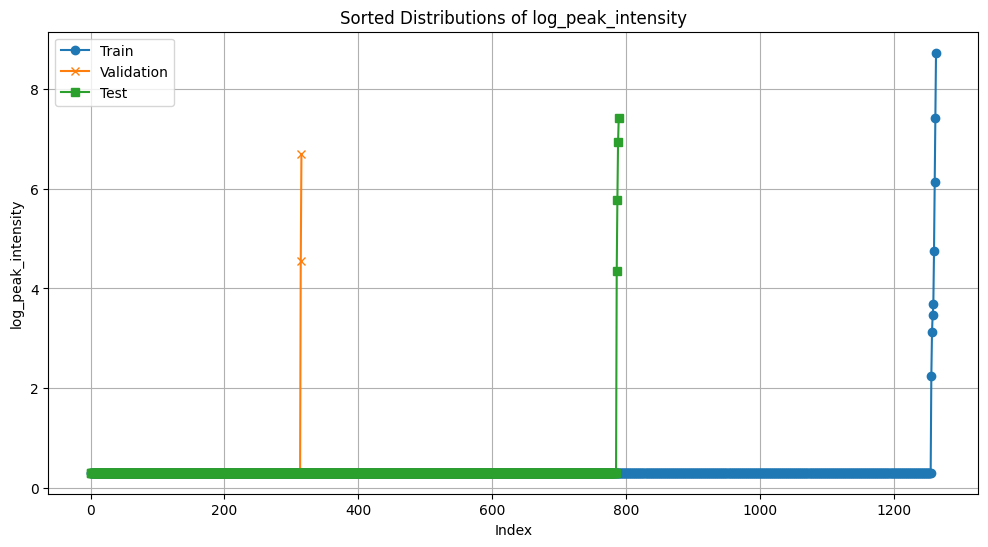

In [5]:
plot_sorted_distributions(train_y, val_y, test_y, title='Sorted Distributions of log_peak_intensity')

In [6]:
def shuffle_sets(train_x, train_y, val_x, val_y, test_x, test_y):
    """
    Shuffle the data within each of the training, validation, and test sets.
    
    :param:
    - train_x, train_y: Numpy arrays containing the training features and labels
    - val_x, val_y: Numpy arrays containing the validation features and labels
    - test_x, test_y: Numpy arrays containing the test features and labels
    
    :return:
    - Shuffled versions of train_x, train_y, val_x, val_y, test_x, test_y
    """
    train_x, train_y = shuffle(train_x, train_y)
    val_x, val_y = shuffle(val_x, val_y)
    test_x, test_y = shuffle(test_x, test_y)
    
    return train_x, train_y, val_x, val_y, test_x, test_y

# Shuffle the datasets
shuffled_train_x, shuffled_train_y, shuffled_val_x, shuffled_val_y, shuffled_test_x, shuffled_test_y = shuffle_sets(train_x, train_y, val_x, val_y, test_x, test_y)


In [7]:
from models import modeling
from sklearn.manifold import TSNE

In [8]:
mb = modeling.ModelBuilder()

# create my feature extractor
feature_extractor = mb.create_model_feat(inputs=19, feat_dim=9, hiddens=[18])

In [9]:
# print model summary
feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19)]              0         
                                                                 
 dense (Dense)               (None, 18)                360       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 18)                0         
                                                                 
 dense_1 (Dense)             (None, 9)                 171       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 9)                 0         
                                                                 
 normalize_layer (NormalizeL  (None, 9)                0         
 ayer)                                                           
                                                             

In [10]:
# plot model
mb.plot_model(feature_extractor)

In [11]:
def plot_tsne(model, X, y):
    """
    Applies t-SNE to the features extracted by the given model and plots them in 2D.
    The color of the points is determined by their label values.
    
    Parameters:
    - model: Trained feature extractor model
    - X: Input data
    - y: Target labels
    
    Returns:
    - A 2D t-SNE plot
    """
    # Extract features using the trained model
    features = model.predict(X)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(features)
    
    # Create a scatter plot
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y, cmap='viridis', alpha=0.6)

    # Add a color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Label Value')

    plt.title('2D t-SNE Visualization')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    plt.show()

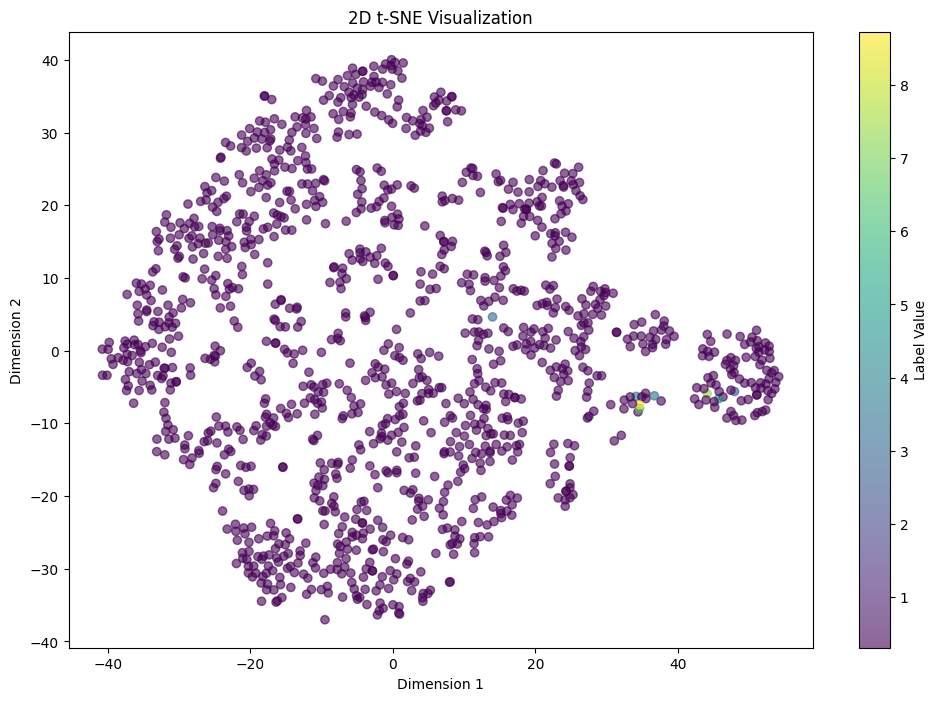

In [12]:
plot_tsne(feature_extractor, shuffled_train_x, shuffled_train_y)

In [14]:
import  random
def find_optimized_random_batch_size(y, threshold=np.log(10), num_trials=1000, early_exit_ratio=0.95):
    """
    Optimized function to find the minimum batch size such that, when sampled at random,
    each batch is likely to contain at least 2 rows with target values greater than a given threshold.
    
    Parameters:
    - y: Numpy array containing the target values
    - threshold: The target threshold, default is ln(10)
    - num_trials: Number of trials to perform for each batch size
    - early_exit_ratio: The success ratio to achieve before stopping the trials for a given batch size
    
    Returns:
    - Minimum batch size that fulfills the condition
    """
    # Count the number of elements greater than the threshold
    count_above_threshold = np.sum(y > threshold)
    
    # If there are fewer than 2 elements above the threshold, return a message
    if count_above_threshold < 2:
        raise ValueError("There are not enough samples with target values greater than the threshold.")
    
    # Loop through possible batch sizes, starting from 2
    for batch_size in range(2, len(y) + 1):
        success_count = 0
        
        for trial in range(num_trials):
            # Sample a random batch
            random_batch = random.sample(list(y), batch_size)
            
            # Check if the batch contains at least 2 elements greater than the threshold
            if np.sum(np.array(random_batch) > threshold) >= 2:
                success_count += 1
            
            # Early exit if success ratio is achieved
            if trial >= 1000 and success_count / (trial + 1) >= early_exit_ratio:
                return batch_size

# # Find the minimum batch size for the training set that satisfies the condition, using the optimized function
# min_optimized_random_batch_size = find_optimized_random_batch_size(train_y, num_trials=10000, early_exit_ratio=0.99)
# 
# min_optimized_random_batch_size


In [15]:
mb.train_features_fast(feature_extractor, shuffled_train_x, shuffled_train_y, shuffled_val_x, shuffled_val_y, epochs=200, batch_size=768)

Run the command line:
 tensorboard --logdir logs/fit
Epoch 1/200


ResourceExhaustedError: Graph execution error:

Detected at node 'repr_loss_fast/mul_1' defined at (most recent call last):
    File "C:\Users\the_3\anaconda3\envs\aip\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\the_3\anaconda3\envs\aip\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\the_3\anaconda3\envs\aip\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\the_3\anaconda3\envs\aip\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\the_3\anaconda3\envs\aip\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\the_3\AppData\Local\Temp\ipykernel_12800\1970438104.py", line 1, in <module>
      mb.train_features_fast(feature_extractor, shuffled_train_x, shuffled_train_y, shuffled_val_x, shuffled_val_y, epochs=200, batch_size=768)
    File "C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\models\modeling.py", line 424, in train_features_fast
      history = model.fit(X_train, y_train,
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\engine\training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\models\modeling.py", line 715, in repr_loss_fast
      err_matrix = self.error_vectorized(z1, z2, label1, label2)
    File "C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\models\modeling.py", line 690, in error_vectorized
      squared_difference = 0.5 * tf.square(z_distance - y_distance)
Node: 'repr_loss_fast/mul_1'
failed to allocate memory
	 [[{{node repr_loss_fast/mul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1065]

In [ ]:
plot_tsne(feature_extractor, shuffled_train_x, shuffled_train_y)

In [ ]:
plot_tsne(feature_extractor, shuffled_test_x, shuffled_test_y)